In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib as mpl
import pandas as pd
from sklearn.svm import SVC

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For each given hyperparameter setting (kernel and regularisation) you will have to do some exploring to find the right learning rate to use in gradient descent. The optimisation learning rate is not a model hyperparameter and hence can be chosen based on just the training set. i.e. choose the learning rate for which the training loss decreases the most.

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [2]:
def sigmoid(z,n):
    z=[1/(1+np.exp(float(i))) if float(i)<709 else 0 for i in z]
    return np.array(z).reshape(n,-1)

def R_f(z,n):
    z=[-1*float(i) if float(i)<=-709 else np.log(1+np.exp(-1*float(i))) for i in z]
    return np.array(z).reshape(n,1)

def kernel_func(x1,x2,ker,kernel_param):
    if ker=='linear':
        return x1@x2.T
    elif ker=='poly':
        return (1+x1@x2.T)**kernel_param
      

def rbf_kernel(train_X, test_X, kernel_param):
    test_X_tiled = np.tile(test_X, (1, 1, train_X.shape[0])).reshape((test_X.shape[0], train_X.shape[0], test_X.shape[1]))
    temp = np.linalg.norm(test_X_tiled - train_X, axis=2)**2
    Kernel = np.exp(-kernel_param * temp)
    return Kernel
    

def train_pred_logistic_regression(X, Y, kernel='linear', reg_param=0., kernel_param=1., num_iter_gd=100):
    n,d=X.shape
    Y=Y.reshape(n,-1)
    
    K = np.zeros((n,n))
    if(kernel=="rbf"):
        for i in range(X.shape[0]):
            K[i] = np.linalg.norm(X-X[i], axis=1)**2
        K = np.exp(-kernel_param * K)
    else:
        K=kernel_func(X,X,kernel,kernel_param)
        
    alpha=np.zeros(n).reshape(n,-1)
    m=[]
    alphas=[]
    eta= 0.07
    for i in range(300):
        if i%10 == 0:
            eta = eta*0.9

        grad_R=K@(sigmoid(Y*(alpha.T@K).T,n)*(-Y))+(reg_param)*(alpha.T@K).T         
        alpha= alpha-eta*grad_R/np.linalg.norm(grad_R)
        loss=np.sum(R_f(Y*(alpha.T@K).T,n),axis=0)[0]+((reg_param/2)*alpha.T@K@alpha)[0][0]
        m.append(loss)
        alphas.append(np.copy(alpha))
            
    return alphas[m.index(min(m))],min(m)


def test_pred(alpha, train_X, train_Y, test_X, kernel, kernel_param):
    n,d=train_X.shape
    
    y = []
    if kernel == 'rbf':
        K = rbf_kernel(train_X, test_X, kernel_param)
        y_extra = K@alpha
        y=[1 if i[0]>=0 else -1 for i in y_extra]
        
    else:
        K=kernel_func(train_X,test_X,kernel,kernel_param)
        y = K.T@alpha
        y=[1 if i[0]>=0 else -1 for i in y]
    return y




In [3]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below. 

datasets = ['dataset_A.npz', 'dataset_B.npz', 'dataset_C.npz', 'dataset_D.npz']
path="E:\\5th sem\\prml\\prog assgn\\Archive (2)\\"
kernel_set=['linear','rbf','poly']


def get_best_hyperparam(X_train,Y_train,X_valid,Y_valid, kernel):
    kernel_range = []
    reg_range = []
    if kernel == 'rbf':
        kernel_range = [1e-5, 1e-3, 0.1, 1, 10]
        reg_range = [1e-4, 1e-3, 1e-2, 0.1, 1]
    
    elif kernel == 'linear':
        kernel_range = [0]
        reg_range = [1e-4, 1e-3, 1e-2, 0.1, 1, 10]  
    
    else:
        kernel_range = [2, 3, 4, 5]
        reg_range = [1e-4, 1e-3, 1e-2, 0.1, 1]
        
    correct_pred = 0
    best_ker_param = 0
    best_reg_param = 0
    for reg_param in reg_range :
        for ker_param in kernel_range:
            alpha,loss = train_pred_logistic_regression(X_train, Y_train,kernel,reg_param ,ker_param,100)
            y_pred = test_pred(alpha, X_train, Y_train, X_valid, kernel, ker_param)
            temp = sum([1 if y_pred[i]==Y_valid[i] else 0 for i in range(len(Y_valid))])
            temp_loss = 1e8
    
            if(temp > correct_pred and loss < temp_loss):
                temp_loss = loss
                correct_pred = temp
                best_ker_param = float(np.copy(ker_param))
                best_reg_param = float(np.copy(reg_param))
    return(best_ker_param,best_reg_param)

def accuracy(Y_pred,Y_test):
    return sum([1 if Y_pred[i]==Y_test[i] else 0 for i in range(len(Y_test))])/len(Y_test)


global_alpha = []
global_ker_param = []

for file in datasets:
    data = np.load(file) 
    print('Logistic Regression On {}'.format(file[:-4]))
    print()
    
    X = data['arr_0']
    Y = data['arr_1']
    X_test = data['arr_2']
    Y_test = data['arr_3'] 
    
    N = X.shape[0]
    sp=np.int(0.8*N)
    X_train = X[:sp,:]
    X_val = X[sp:,:]
    Y_train = Y[:sp]
    Y_val = Y[sp:]
    
    mean=np.mean(X_train, axis=0)
    
    X_train=X_train-mean
    X_val=X_val-mean
    X_test=X_test-mean
    
    std=np.std(X_train, axis=0)
    
    if std.all()>0:
        X_train=X_train/std
        X_val=X_val/std
        X_test=X_test/std
    
    for kernel in kernel_set:            
        best_ker, best_lambda = get_best_hyperparam(X_train, Y_train, X_val, Y_val,kernel)
        print('================================================================================================')
        print('{} Kernel'.format(kernel))
        print(best_ker, best_lambda)
        
        alpha_star = train_pred_logistic_regression(X_train, Y_train, kernel, best_lambda, best_ker, 100)
        
        global_ker_param.append(np.copy(best_ker))
        global_alpha.append(np.copy(alpha_star[0]))
        
        y_pred = test_pred(alpha_star[0], X_train, Y_train,  X_test , kernel, best_ker)
        y_pred_2 = test_pred(alpha_star[0], X_train, Y_train, X_train, kernel, best_ker)
        AC = accuracy(y_pred,Y_test)
        AC2 = accuracy(y_pred_2,Y_train)
        print('Train_Error - {} , Test_Error - {}'.format(1-AC2,1-AC))



Logistic Regression On dataset_A

linear Kernel
0.0 0.0001
Train_Error - 0.12416666666666665 , Test_Error - 0.132
rbf Kernel
1.0 0.0001
Train_Error - 0.0 , Test_Error - 0.0020000000000000018
poly Kernel
3.0 0.0001
Train_Error - 0.0024999999999999467 , Test_Error - 0.0040000000000000036
Logistic Regression On dataset_B

linear Kernel
0.0 0.0001
Train_Error - 0.1775 , Test_Error - 0.20199999999999996
rbf Kernel
0.1 0.0001
Train_Error - 0.16833333333333333 , Test_Error - 0.19599999999999995
poly Kernel
2.0 0.0001
Train_Error - 0.16833333333333333 , Test_Error - 0.19399999999999995
Logistic Regression On dataset_C

linear Kernel
0.0 0.0001
Train_Error - 0.0708333333333333 , Test_Error - 0.11784511784511786
rbf Kernel
0.1 0.0001
Train_Error - 0.0 , Test_Error - 0.03367003367003363
poly Kernel
3.0 0.001
Train_Error - 0.0 , Test_Error - 0.0572390572390572
Logistic Regression On dataset_D

linear Kernel
0.0 0.0001
Train_Error - 0.021874999999999978 , Test_Error - 0.029585798816568087
rbf Kerne

TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  


### Linear Kernel:

| Dataset | Reg_Param | Train zero-one Error | Test zero-one error |
|---------------|:------------:|:---------------:|:---------------:|
| Data-Set A    |      0.0001     |      0.1241     |      0.1320     |
| Data-Set B    |     0.0001    |      0.1775     |      0.2019     |
| Data-Set C    |    0.0001    |      0.0708      |     0.1178   |
| Data-Set D    |       0.0001      |      0.0218     |      0.0295    |

### RBF Kernel:

| Dataset | Reg_Param | Kernel_param  | Train zero-one Error | Test zero-one error |
|------------|:------------:|:--------:|:---------------:|:---------------:|
| Data-Set A |     0.0001     |   1.0   |      0.0000     |      0.0020     |
| Data-Set B |     0.0001     |   0.1   |      0.1683    |      0.1959     |
| Data-Set C |      0.0001      | 0.1 |      0.0000     |     0.0336     |
| Data-Set D |       0.0001      | 1.0 |      0.0000     |    0.0414     |

### Polynomial Kernel

| Dataset | Reg_Param | Kernel_param | Train zero-one Error | Test zero-one error |
|-------------|:------------:|:--------:|:---------------:|:---------------:|
| Data-Set A  |     0.0001     |   3   |       0.0025      |      0.0040     |
| Data-Set B  |      0.0001     |   2   |      0.1683   |     0.1939    |
| Data-Set C  |    0.001   |   3   |       0.0000      |     0.0572     |
| Data-Set D  |      0.0001    |   2    |      0.0218        |      0.0473    |


### Best Kernel and Parameters for each dataset

| **Dataset** 	| **Best Kernel** 	| **Best Reg Param** 	| **Best Kernel Param** 	|
|:-----------:	|:---------------:	|:------------------:	|:---------------------:	|
|      A      	|       RBF       	|       0.0001       	|           1           	|
|      B      	|    POLYNOMIAL   	|       0.0001       	|           2           	|
|      C      	|       RBF       	|       0.0001       	|          0.1          	|
|      D      	|      LINEAR     	|       0.0001       	|           -           	|



## OBSERVATIONS

1) Linear Kernel's Performance on Dataset B is better when compared with the other datasets.

2) RBF Kernel performs well on all datasets other than Dataset B . Its performance is similar to that of Linear Kernel on          Dataset B

3) Polynomial Kernel's performance is on par with RBF kernel .It's performance is also similar to linear kernel with Dataset B

4)The choice of kernel is dependent on the distribution of the data. Hence some  kernels perform very well on certain kinds of      data, while some others perform poorly on the same data

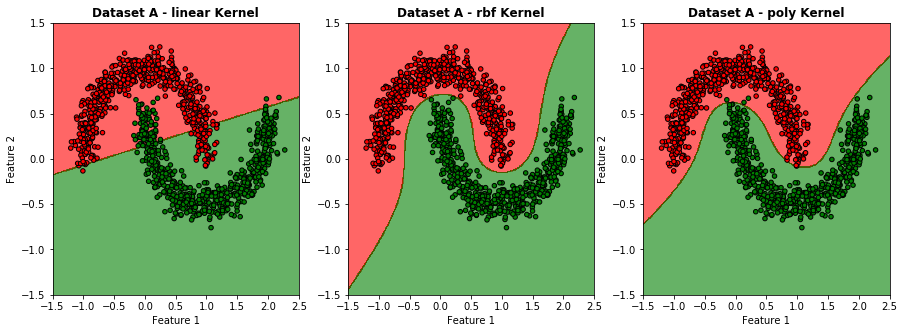

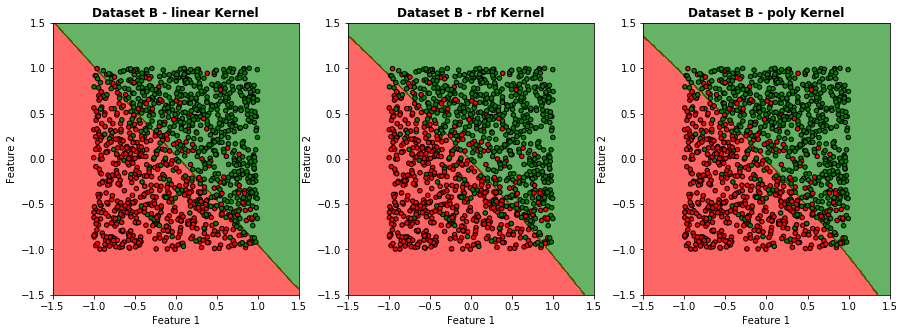

In [4]:

def plotting(alpha1,best_ker_par,ax, kernel, X_train, Y_train):
    
    #splitting the data into training and validation sets
   
    N = X_train.shape[0]
    sp=np.int(0.8*N)
    x_train = X_train[:sp,:]
    y_train = Y_train[:sp]
    x_val = X_train[sp:,:]
    y_val = Y_train[sp:]
    
    x_plot = X_train[:sp,:]
    y_plot = Y_train[:sp]
    
    x_min = round(x_train[:, 0].min())-0.5
    y_min = round(x_train[:, 1].min())-0.5
    x_max = round(x_train[:, 0].max())+0.5
    y_max = round(x_train[:, 1].max())+0.5
    
    mean = np.mean(x_train, axis=0)
    
    x_train = x_train - mean
    x_val = x_val-mean
    
    std = np.std(x_train, axis=0)
    
    if std.all()>0:
        x_train = x_train/std
        
        x_val = x_val/std
        
    
    # axes limits
    
    
    # Generate meshgrids
    x1 = np.linspace(x_min, x_max, 300)
    x2 = np.linspace(y_min, y_max, 300)
    
    xx, yy = np.meshgrid(x1, x2)
    
    x1=np.c_[xx.ravel(), yy.ravel()]
    x1=x1-mean
    if std.all()>0:
        x1=x1/std
        
    
    z = test_pred(alpha1, x_train, y_train,x1 , kernel, best_ker_par)
    zz = np.array(z).reshape(xx.shape)
    
    # Plotting
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    ax.contourf(xx, yy, zz, colors=['r','g'],alpha=0.6)
    ax.scatter(x_plot[:, 0], x_plot[:, 1], c=['green' if i==1 else 'red' for i in y_plot], s=20, edgecolor='black') 
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    
    return ax

 
    
datasets = ['dataset_A.npz','dataset_B.npz']
path="E:\\5th sem\\prml\\prog assgn\\Archive (2)\\"
kernel_set=['linear','rbf','poly']
k=0
for file in datasets:
    data = np.load(file)    
    x_train = data['arr_0']
    y_train = data['arr_1']
    x_test = data['arr_2']
    y_test = data['arr_3'] 

    fig = plt.figure(figsize=(15, 5))
    for i in range(3):
        ax = fig.add_subplot(1, 3, i+1)
        index = (i // 3) + 1
        j = i % 3
        best_ker = global_ker_param[k]
        alpha1 = global_alpha[k]
        k+=1
        plotting(alpha1,best_ker,ax, kernel_set[j], x_train, y_train)
        plt.title('Dataset {} - {} Kernel'.format(file[-5], kernel_set[j]), fontweight='bold')

# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [5]:
def train_SVM(kernel,x_train, y_train, x_val, y_val,reg_param,kernel_param=None,kernel_deg=None):
    
    if kernel=='linear':
        model =  SVC(C = reg_param, kernel='linear')
        model.fit(x_train ,y_train)
        train_score = model.score(x_train, y_train)
        val_score = model.score(x_val, y_val)
        
    elif kernel=='rbf':
        model = SVC(C = reg_param, kernel = 'rbf', gamma = kernel_param)
        model.fit(x_train, y_train)
        train_score = model.score(x_train, y_train)
        val_score = model.score(x_val, y_val)
    else:
        model = SVC(C = reg_param, kernel = 'poly', degree = kernel_deg, gamma = 1, coef0 = 1.0, tol = 0.01)
        model.fit(x_train, y_train)
        train_score = model.score(x_train, y_train)
        val_score = model.score(x_val, y_val)
        
    return train_score, val_score

def SVM_predict(kernel,data_x, data_y, x_test, reg_param, kernel_deg=None,kernel_param=None):
    
    if kernel=='linear':
        model = SVC(C = reg_param, kernel = 'linear')
        model.fit(data_x, data_y)
        
    elif kernel=='rbf':
        model = SVC(C = reg_param, kernel = 'rbf', gamma = kernel_param)
        model.fit(data_x, data_y)
        
    else:
        model = SVC(C = reg_param, kernel = 'poly', degree = kernel_deg, gamma = 1, coef0 = 1.0, tol = 0.01)
        model.fit(data_x, data_y)
        
    return model.predict(x_test)
        
    

In [6]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.

datasets = ['dataset_A.npz', 'dataset_B.npz', 'dataset_C.npz', 'dataset_D.npz']
path="E:\\5th sem\\prml\\prog assgn\\Archive (2)\\"
Best_reg=[]
Best_gamma=[]
Best_deg=[]
for file in datasets:
    
    data = np.load(file)
    
    X = data['arr_0']
    Y = data['arr_1']
    X_test = data['arr_2']
    Y_test = data['arr_3']
    
    print("------------------------------- SVM for {} -----------------------------".format(file[:-4]))
    N = X.shape[0]
    sp=np.int(0.8*N)
    X_train = X[:sp,:]
    X_val = X[sp:,:]
    Y_train = Y[:sp]
    Y_val = Y[sp:]
    
    mean=np.mean(X_train, axis=0)
    
    X_train=X_train-mean
    X_val=X_val-mean
    X_test=X_test-mean
    
    std=np.std(X_train, axis=0)
    
    if std.all()>0:
        X_train=X_train/std
        X_val=X_val/std
        X_test=X_test/std
    

    for i in ['linear','rbf','poly']:
        
        if i=='linear':
            
            print("Best Parameters for Linear Kernel\n")

            reg_param = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,100]
            best_score = 0
            best_reg_param = 0
            for r in reg_param: 
                train_score, val_score = train_SVM('linear',X_train, Y_train, X_val, Y_val, r)
                if val_score > best_score:
                    best_reg_param = r
                    best_score = val_score

            print('Best Regularisation Parameter: ', best_reg_param)
            train_score, test_score = train_SVM('linear',X_train, Y_train, X_test, Y_test, best_reg_param)
            
        elif i=='rbf':
            
            print(" Best Parameters for RBF Kernel\n")

            reg_param = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10,100]
            gamma = [0.0001, 0.01, 0.1, 1, 5, 10, 50, 100]
            best_score = 0
            best_reg_param = 0
            best_gamma = 0
            for r in reg_param:
                for g in gamma:
                    train_score, val_score = train_SVM('rbf',X_train, Y_train, X_val, Y_val, r, kernel_param=g)
                    if val_score > best_score:
                        best_reg_param = r
                        best_gamma = g
                        best_score = val_score
            Best_gamma.append(best_gamma)
            print('Best Regularisation Parameter: ', best_reg_param)
            print("Best Gamma : ", best_gamma)
            train_score, test_score = train_SVM('rbf',X_train, Y_train, X_test, Y_test, best_reg_param, kernel_param=best_gamma)
            
        else:
            
            print(" Best Parameters for Polynomial Kernel\n")
            
            reg_param = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1,100]
            degree = [i for i in range(1,8)]
            best_score = 0
            best_reg_param = 0
            best_deg = 0
            for r in reg_param:
                for deg in degree:
                    train_score, val_score = train_SVM('poly',X_train, Y_train, X_val, Y_val, r, kernel_deg=deg)
                    if val_score > best_score:
                        best_reg_param = r
                        best_deg = deg
                        best_score = val_score
                        
            Best_deg.append(best_deg)
            print('Best Regularisation Parameter: ', best_reg_param)
            print('Best Polynomial Degree: ', best_deg)
            train_score, test_score = train_SVM('poly',X_train, Y_train, X_test, Y_test, best_reg_param, kernel_deg=best_deg)
            
        Best_reg.append(best_reg_param)   
        print("Train - Accuracy: ", 100*train_score)
        print("Test  - Accuracy: ", 100*test_score)
        print("Train - Zero-one Error: ", 100*(1 - train_score))
        print("Test  - Zero-one Error: ", 100*(1 - test_score))
        print()
        print('****************************************************************************************************************')
        print()

------------------------------- SVM for dataset_A -----------------------------
Best Parameters for Linear Kernel

Best Regularisation Parameter:  0.5
Train - Accuracy:  87.33333333333333
Test  - Accuracy:  87.2
Train - Zero-one Error:  12.666666666666671
Test  - Zero-one Error:  12.8

****************************************************************************************************************

 Best Parameters for RBF Kernel

Best Regularisation Parameter:  0.05
Best Gamma :  5
Train - Accuracy:  99.83333333333333
Test  - Accuracy:  99.6
Train - Zero-one Error:  0.16666666666667052
Test  - Zero-one Error:  0.40000000000000036

****************************************************************************************************************

 Best Parameters for Polynomial Kernel

Best Regularisation Parameter:  0.005
Best Polynomial Degree:  5
Train - Accuracy:  99.83333333333333
Test  - Accuracy:  99.6
Train - Zero-one Error:  0.16666666666667052
Test  - Zero-one Error:  0.400000000


# List of hyper parameters


### Linear Kernel:

| Dataset | Reg_Param | Train zero-one Error | Test zero-one error |
|---------------|:------------:|:---------------:|:---------------:|
| Data-Set A    |      0.5     |      0.12667     |      0.12800    |
| Data-Set B    |     0.1    |      0.17004     |      0.19599    |
| Data-Set C    |    100    |      0.05583     |     0.10437   |
| Data-Set D    |       0.0005      |      0.09062     |      0.02366    |

### RBF Kernel:

| Dataset | Reg_Param | Gamma  | Train zero-one Error | Test zero-one error |
|------------|:------------:|:--------:|:---------------:|:---------------:|
| Data-Set A |     0.05     | 5     |      0.00167     |      0.00400    |
| Data-Set B |     5     | 0.01    |      0.16916    |      0.19399     |
| Data-Set C |      100      | 0.0001 |      0.00000     |     0.03703     |
| Data-Set D |       0.5      | 0.01 |      0.02187     |    0.01775    |

### Polynomial Kernel

| Dataset | Reg_Param | Degree | Train zero-one Error | Test zero-one error |
|-------------|:------------:|:--------:|:---------------:|:---------------:|
| Data-Set A  |     0.005     |   5   |       0.00166      |      0.00400     |
| Data-Set B  |      0.1      |   1   |      0.17000    |     0.19599    |
| Data-Set C  |    0.0001   |   3    |       0.00000      |     0.01347     |
| Data-Set D  |      0.0001    |   1    |      0.00312        |      0.03550    |



## OBSERVATIONS

1) SVM with RBF and Polynomial kernel performs equally well on all the datasets when compared with Linear kernel.

2) Polynomial Kernel with degree 1 (similar to linear kernel) performs best over other degrees on Dataset B because of the           linearly separable nature of Dataset B

3) RBF and polynomial kernels gave best results on dataset A.

4) The performance of all kernels is more or less the same on Dataset B.

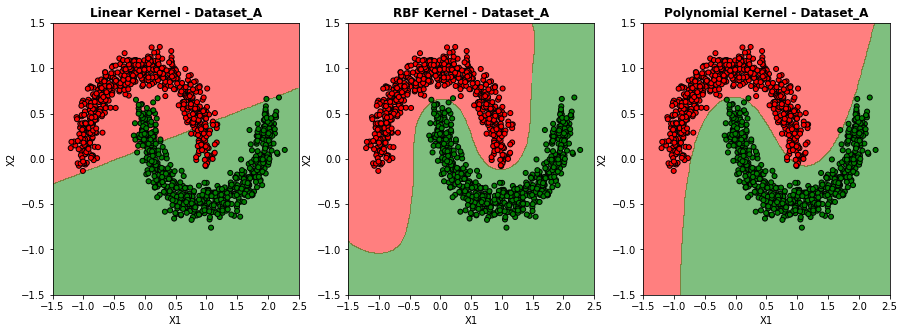

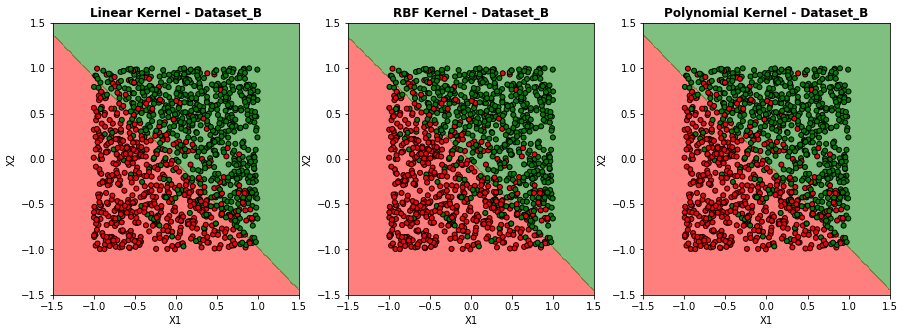

In [7]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

datasets = ['dataset_A.npz', 'dataset_B.npz']
path="E:\\5th sem\\prml\\prog assgn\\Archive (2)\\"
for file in datasets:
    
    data = np.load(file)
    
    X = data['arr_0']
    Y = data['arr_1']
    X_test = data['arr_2']
    Y_test = data['arr_3']
    
    
    N = X.shape[0]
    sp=np.int(0.8*N)
    X_train = X[:sp,:]
    Y_train = Y[:sp]


    #Y_train = Y_train.astype(int)
    
    # axes limits
    x_min = round(X_train[:, 0].min())-0.5
    y_min = round(X_train[:, 1].min())-0.5
    x_max = round(X_train[:, 0].max())+0.5
    y_max = round(X_train[:, 1].max())+0.5
    
    # Generate meshgrids
    x1 = np.linspace(x_min, x_max, 300)
    x2 = np.linspace(y_min, y_max, 300)
    
    xx, yy = np.meshgrid(x1, x2)
    

    if file == 'dataset_A.npz':
        
        reg_param = [0.5, 0.05, 0.005]
        other_param = [5, 5]
    else:
        
        reg_param = [0.1, 5, 0.1]
        other_param = [0.01, 1]

    linear_plot = np.array([SVM_predict('linear',X_train,Y_train,np.c_[xx.ravel(), yy.ravel()],reg_param[0])])
    linear_plot = linear_plot.reshape(xx.shape)
    rbf_plot = np.array([SVM_predict('rbf',X_train,Y_train,np.c_[xx.ravel(), yy.ravel()],reg_param[1],kernel_param=other_param[0])])
    rbf_plot = rbf_plot.reshape(xx.shape)
    poly_plot = np.array([SVM_predict('poly',X_train,Y_train,np.c_[xx.ravel(), yy.ravel()],reg_param[2],kernel_deg=other_param[1])])
    poly_plot = poly_plot.reshape(xx.shape)
    
    plots=[linear_plot,rbf_plot,poly_plot]
    names=['Linear','RBF','Polynomial']
    
    fig=plt.figure(figsize = (15,5))
    
    for i in range(3):
        ax= fig.add_subplot(1,3,i+1)
        plot = ax.contourf(xx, yy, plots[i], levels =np.arange(-1,2), colors = ('r','g'), alpha =0.5)
        ax.scatter(X_train[:,0], X_train[:,1], c = ['g' if i==1 else 'r' for i in Y_train], s = 25,edgecolor='black')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        plt.title(names[i]+" Kernel - {}".format('D'+file[1:-4]), fontweight='bold')
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        
        

    plt.show()



# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all four data sets  report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [8]:
# CodeWrite cell
# Write Decision tree classifier from scratch, 
# write only functions here (you may write extra functions here if you wish)

class Decision_tree_node:
    def __init__(self, sp_col, val, que, label, cr):
        self.left = None
        self.right = None
        self.split_col = sp_col
        self.thres_val = val
        self.label = label        
        self.que_type = que
        self.criteria = cr
        
def get_splits(data, rand_choice):    
   
    potential_splits = {}
    column_indices = list(range(data.shape[1]- 1))
    
    if rand_choice:
        column_indices = np.random.choice(data.shape[1] - 1, rand_choice, replace = True)
        
    for col_ind in column_indices:
        x_min, x_max = data[:,col_ind].min() , data[:,col_ind].max() 
        if (x_min != x_max):
            
            potential_splits[col_ind]=np.linspace(x_min + (x_max-x_min)/10, x_max - (x_max-x_min)/10, 10).tolist()
    
    #print(potential_splits)
    return potential_splits



def entropy(data):

    if(np.all(data[:, -1] == 1) or np.all(data[:, -1] == -1)):
        entropy = 0
        
    elif(sum(data[:,-1]) == 0):
        entropy = 1
        
    else:
        label_column = data[:, -1]
        _, counts = np.unique(label_column, return_counts=True)
        probabilities = counts / counts.sum()
        entropy = sum(probabilities*(-np.log2(probabilities)))
    return entropy


def tot_entropy(data_left, data_right):
    

    p_data_left =  len(data_left) / (len(data_left) + len(data_right))
    p_data_right = len(data_right) / (len(data_left) + len(data_right))
    
    return (p_data_left*entropy(data_left)) + (p_data_right*entropy(data_right))


def accuracy(data, split_column, split_value):
    
    label_column = data[:, -1].reshape(-1,1)
    label_temp = np.zeros((data.shape[0], 2))
    for ind in range(data.shape[0]):
        if(data[ind, split_column] >= split_value):
            label_temp[ind, 0] = 1
            label_temp[ind, 1] = -1
        else:
            label_temp[ind, 0] = -1
            label_temp[ind, 1] = 1
            
    acc = np.sum(label_temp == label_column, axis = 0)/data.shape[0]
    max_acc_loc = np.max(acc[:,None])
    max_acc_loc_ind = np.argmax(acc)
    
    return max_acc_loc, max_acc_loc_ind
    

def best_split(data, potential_splits, criterion):
    
    
    best_split_col = 0
    best_split_value = 0
    question_type = 0
    
    if(criterion == "entropy"):
        overall_entropy = 1
        for col_ind in potential_splits:
            for value in potential_splits[col_ind]:
                data_left, data_right = split_data(data, col_ind, value)
                curr_overall_entropy = tot_entropy(data_left, data_right)

                if(curr_overall_entropy <= overall_entropy):
                    best_split_col ,best_split_value,overall_entropy= col_ind,value,curr_overall_entropy
                  
    else:
        max_accuracy = 0
        for col_ind in potential_splits:
            if(len(potential_splits[col_ind]) != 0):
                for value in potential_splits[col_ind]:
                    current_accuracy, question_type = accuracy(data, col_ind, value)
        
                    if(current_accuracy >= max_accuracy):
                        best_split_col = col_ind
                        best_split_value = value
                        question_type = question_type
                        max_accuracy = current_accuracy
        
        #print(max_accuracy)
            
    return best_split_col, best_split_value, question_type

def split_data(data, split_feature, split_value, question_type = 0):
     
    if(question_type == 0):
        
        data_right = data[data[:, split_feature] >= split_value]
        data_left = data[data[:, split_feature] < split_value]
    else:
        
        data_right = data[data[:, split_feature] <= split_value]
        data_left = data[data[:, split_feature] > split_value]
    
    return data_left, data_right


def classify_data(data):
    
    unique_classes, counts = np.unique(data[:, -1], return_counts=True) 
    return unique_classes[counts.argmax()]

def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy', rand_choice=None):
    data = np.concatenate((X, Y[:, None]), axis = 1)
    m, n = data.shape
    
    if(m <= num_nodes_stop) or np.all(data[:,-1] == 1) or np.all(data[:,-1] == -1):       
        class_label = classify_data(data)
        
        return Decision_tree_node(None, None, None, class_label, criterion)
    
    potential_splits = get_splits(data, rand_choice)
    split_column, split_value, question_type = best_split(data, potential_splits, criterion)
    data_left, data_right = split_data(data, split_column, split_value, question_type)
    
    get_node = Decision_tree_node(split_column, split_value, question_type, None, criterion)
        
    if(len(data_left) == 0 or len(data_right) == 0):
        cf = classify_data(data)
        get_node.label = cf
        return get_node
        
# tree of the form -- {"split_column question type split value":[1, {"---":[-1, {"---":[{"---":[---]},{"---":[---]}]}]}]}
# split column --> feature , split value --> threshold 
# question type : 0 - split column(feature)  >= threshold(split value) ; 1 - split column(feature) <= threshold(split value)
            
    if(question_type == 0):        

        get_node.left = train_decision_tree(data_left[:, :n-1], data_left[:, -1], num_nodes_stop, criterion, rand_choice)
        get_node.right = train_decision_tree(data_right[:,:n-1], data_right[:,-1], num_nodes_stop, criterion, rand_choice)
        
        return get_node

    else:
        
        get_node.left = train_decision_tree(data_left[:, :n-1], data_left[:, -1], num_nodes_stop, criterion, rand_choice)
        get_node.right = train_decision_tree(data_right[:,:n-1], data_right[:,-1], num_nodes_stop, criterion, rand_choice)
        
        return get_node
    
    
def classify_sample(tree,X):
    if tree.que_type == None:
        return tree.label
    elif int(tree.que_type) == 0:
        if X[tree.split_col] >= tree.thres_val:
            if tree.label != None:
                return tree.label
            return classify_sample(tree.right,X)
        else:
            if tree.label != None:
                return tree.label
            return classify_sample(tree.left,X)
    elif int(tree.que_type) == 1:
        if X[tree.split_col] <= tree.thres_val:
            if tree.label != None:
                return tree.label
            return classify_sample(tree.right,X)
        else:
            if tree.label != None:
                return tree.label
            return classify_sample(tree.left,X)    
            
def eval_decision_tree(tree, test_X):
    Y_pred = []
    for i in test_X:
        ans = classify_sample(tree,i)
        Y_pred.append(ans)
    
    return np.array(Y_pred)


In [9]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.

datasets = ['dataset_A.npz', 'dataset_B.npz','dataset_C.npz', 'dataset_D.npz']
path="E:\\5th sem\\prml\\prog assgn\\Archive (2)\\"

split_Eval_criteria = {"accuracy": {}, "entropy": {}}

for criterion in list(split_Eval_criteria.keys()):
    
    #print("Split evaluation criterion = ", criterion)
    for file in datasets:
        ## loading the data
        data = np.load(file)

        X_train = data["arr_0"]
        Y_train = data["arr_1"]
        X_test = data["arr_2"]
        Y_test = data["arr_3"]
        
        N = X_train.shape[0]
        sp=np.int(0.8*N)
        x_train = X_train[:sp,:]
        x_val = X_train[sp:,:]
        y_train = Y_train[:sp]
        y_val = Y_train[sp:]


        stop_nodes = [1,4,5,10,15,16,20,30,32,35,60,64,65]
        best_accuracy = 0
        best_ac=0
        best_parameter = 0
        
        for num_nodes in stop_nodes:
            tree = train_decision_tree(x_train, y_train, num_nodes, criterion)
            y_pred_train = eval_decision_tree(tree, x_train)
            y_pred_val = eval_decision_tree(tree, x_val)
            train_accuracy = np.mean(y_pred_train == y_train)
            val_accuracy = np.mean(y_pred_val == y_val)
            
                
            if(val_accuracy > best_accuracy ):
                best_parameter = num_nodes
                best_accuracy = val_accuracy
                best_tree = tree
                best_ac=train_accuracy
            
                
            #print(" {} , {} ,{}  num_nodes parameter = {} \n".format(train_accuracy,val_accuracy,file[:-4], num_nodes))
        
        # performance with the best parameters
        y_pred_train = eval_decision_tree(best_tree, x_train)
        y_pred_test = eval_decision_tree(best_tree, X_test)
        train_accuracy = np.mean(y_pred_train == y_train)
        test_accuracy = np.mean(y_pred_test == Y_test)
        split_Eval_criteria[criterion][file] = [best_parameter, 1-train_accuracy, 1-test_accuracy, best_tree]
        print("Eval done on {} \n".format(file[:-4]))
        print("Best_Parameters : {}\n".format(split_Eval_criteria[criterion][file][:3]))

Eval done on dataset_A 

Best_Parameters : [10, 0.035833333333333384, 0.06000000000000005]

Eval done on dataset_B 

Best_Parameters : [35, 0.16083333333333338, 0.20199999999999996]

Eval done on dataset_C 

Best_Parameters : [15, 0.0625, 0.12121212121212122]

Eval done on dataset_D 

Best_Parameters : [15, 0.046875, 0.08875739644970415]

Eval done on dataset_A 

Best_Parameters : [32, 0.0016666666666667052, 0.008000000000000007]

Eval done on dataset_B 

Best_Parameters : [10, 0.10999999999999999, 0.22999999999999998]

Eval done on dataset_C 

Best_Parameters : [5, 0.008333333333333304, 0.08417508417508412]

Eval done on dataset_D 

Best_Parameters : [1, 0.0, 0.07692307692307687]



TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  

## SPLIT CRITERION AND LIST OF PARAMETERS


### ACCURACY



| **Dataset\Error** 	| **Best Node Stop Size** 	| **Train Error** 	| **Test Error** 	|
|:-----------------:	|:-----------------------:	|:---------------:	|:--------------:	|
|         A         	|            10           	|      0.0358     	|     0.0600     	|
|         B         	|            35           	|      0.1608     	|     0.2020     	|
|         C         	|            15           	|      0.0625     	|     0.1212     	|
|         D         	|            15           	|      0.0469     	|     0.0888     	|


### ENTROPY



| **Dataset\Error** 	| **Best Node Stop Size** 	| **Train Error** 	| **Test Error** 	|
|:-----------------:	|:-----------------------:	|:---------------:	|:--------------:	|
|         A         	|            32           	|      0.0167     	|     0.0080     	|
|         B         	|            10           	|      0.1608     	|     0.2020     	|
|         C         	|            5            	|      0.0083     	|     0.0842        |
|         D         	|            1            	|      0.0000     	|     0.0769     	|


## OBSERVATIONS

1) When the number of stop nodes is 1 , the training error is 0 and the test error is non-zero but tiny in the above case.This      might sometimes result in overfitting but it hasnt in our case.(might be due to the nature of datasets).

2) It can be observed that the train and test error obtained via entropy criterion are less compared to that obtained using        accuracy criterion.

3) The num_nodes_stop parameter is used to take care of overfitting i.e the model overfits for very low values and gives a          decent fit for higher range values (hyperparameter). Its used to prune the tree. But in our case for Dataset D ,best results    have been obtained for num_nodes_stop=1 which means the model did not overfit

4) The performance of dataset-B is poor because of the way the data actually is . The data is spread uniformly along both the      axes.The num_nodes_parameter played a crucial part to avoid overfitting.

5) Training the decision tree algorithm took long time (mainly for dataset c) due to the brute force approach adopted(which        involves considering each feature and the range of values feature can take).The time taken depends on the no. of features and    the range of values the features take and also on the no. of split values one considers.







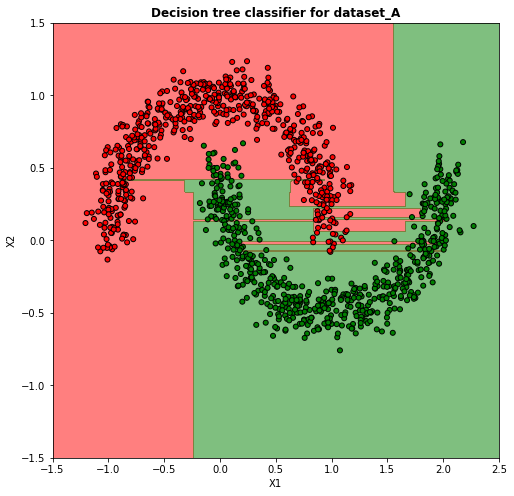

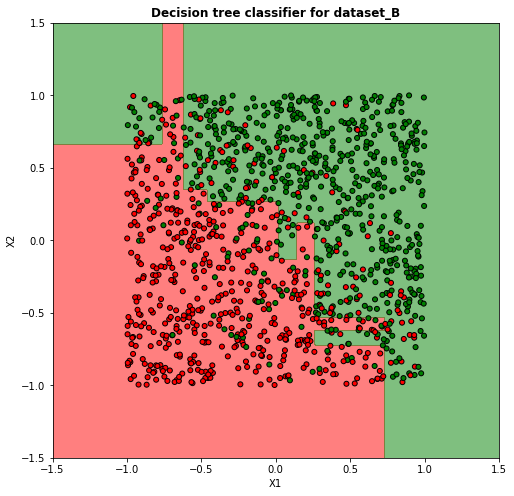

In [10]:
datasets = ['dataset_A.npz', 'dataset_B.npz']
path="E:\\5th sem\\prml\\prog assgn\\Archive (2)\\"
for file in datasets:
# loading the data
    data = np.load(file)

    X_train = data["arr_0"]
    Y_train = data["arr_1"]
    X_test = data["arr_2"]
    Y_test = data["arr_3"]

    N = X_train.shape[0]
    sp=np.int(0.8*N)
    x_train = X_train[:sp,:]
    y_train = Y_train[:sp]
    x_val = X_train[sp:,:]
    y_val = Y_train[sp:]
    
    x_plot = X_train[:sp,:]
    y_plot = Y_train[:sp]
    
        
    x_min = round(x_train[:, 0].min())-0.5
    y_min = round(x_train[:, 1].min())-0.5
    x_max = round(x_train[:, 0].max())+0.5
    y_max = round(x_train[:, 1].max())+0.5
    
    # axes limits
    
    
    # Generate meshgrids
    x1 = np.linspace(x_min, x_max, 300)
    x2 = np.linspace(y_min, y_max, 300)
    
    xx, yy = np.meshgrid(x1, x2)

    tree = split_Eval_criteria["accuracy"][file][3]
            
    Z = eval_decision_tree(tree, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)  
    
    
    fig=plt.figure(figsize = (8,8))
    ax=fig.add_subplot(1,1,1)
    ax.contourf(xx, yy, Z,colors = ('r','g'), levels =np.arange(-1,2), alpha = 0.5)
    ax.scatter(x_plot[:,0], x_plot[:,1], c = ['g' if i==1 else 'r' for i in y_plot], s = 25,edgecolor='black')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.title("Decision tree classifier for {}".format(file[:-4]),fontweight='bold')
    plt.xlabel("X1")
    plt.ylabel("X2")
plt.show()



# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5, num_nodes_stop=1).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [11]:

def train_random_forest(X, Y, num_trees=10, num_nodes_stop=1, criterion='accuracy', a=0.5, b=0.5):
    
    """ Returns a random forest trained on X and Y. 
    Trains num_trees.
    Stops splitting nodes in each tree when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Fraction of data used per tree = a
    Fraction of features used in each node = b
    Returns a random forest (In whatever format that you find appropriate)

    """    
    RF=[]
    
    while num_trees!=0:
        
        data = np.concatenate((X, Y[:, None]), axis = 1)
        frac_data = round(a*data.shape[0])
        frac_num_features = round(b*(data.shape[1] - 1))

        sample_data = data[np.random.randint(0, len(data), frac_data)]
        X_sample = sample_data[:, :-1]
        Y_sample = sample_data[:, -1]
        tree = train_decision_tree(X_sample, Y_sample, num_nodes_stop, criterion, frac_num_features)
        RF.append(tree)
        num_trees -= 1
    
    return RF 
           
    
    
def eval_random_forest(random_forest, test_X):
    
    """ Takes in a  random forest object (hhowever you want to store it), and a bunch of instances X and 
    returns the tree predicted values at those instances."""  

    predictions = np.zeros((test_X.shape[0], len(random_forest)))
    
    for tree in range(len(random_forest)):
        
        predictions[:, tree] = eval_decision_tree(random_forest[tree], test_X)
        
    y_pred = [np.unique(predictions[i, :], return_counts=True) for i in range(len(predictions))]
    
    y_vote_pred = np.array([y_pred[i][0][np.argmax(y_pred[i][1])] for i in range(len(predictions))])
    
    y_vote_pred=y_vote_pred.tolist()
    y_vote_pred=np.array([1 if i==0 else i for i in y_vote_pred])
    
    return y_vote_pred


In [12]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also.

datasets = ['dataset_A.npz', 'dataset_B.npz','dataset_C.npz', 'dataset_D.npz']
path="E:\\5th sem\\prml\\prog assgn\\Archive (2)\\"

split_Eval_criteria = {"accuracy": {}, "entropy": {}}
for criterion in list(split_Eval_criteria.keys()):
    print("Split evaluation criterion = {} \n".format(criterion))
    
    for file in datasets:
        ## loading the data
        data = np.load(file)

        X_train = data["arr_0"]
        Y_train = data["arr_1"]
        X_test = data["arr_2"]
        Y_test = data["arr_3"]
        
        N = X_train.shape[0]
        sp=np.int(0.8*N)
        x_train = X_train[:sp,:]
        x_val = X_train[sp:,:]
        y_train = Y_train[:sp]
        y_val = Y_train[sp:]

                        
        Number_of_trees =  [1,5,10,11,20,21,30,40] #hyperparameter

        best_accuracy = 0
        best_num_trees = 0
        
        for num_trees in Number_of_trees:
            
            rf = train_random_forest(x_train, y_train, num_trees, 1, criterion, 0.5,0.5)
            y_pred_train = eval_random_forest(rf, x_train)
            y_pred_valid = eval_random_forest(rf, x_val)
            train_accuracy = np.mean(y_pred_train == y_train)
            val_accuracy = np.mean(y_pred_valid == y_val)
            
            if(val_accuracy >= best_accuracy):
                best_num_trees = num_trees
                best_accuracy = val_accuracy
                forest_best = rf
                
            #print("{} , {} , {} for num_trees parameter = {} \n".format(train_accuracy,val_accuracy,file[:-4], num_trees))
        
        # performance with the best parameters
        y_pred_train = eval_random_forest(forest_best, x_train)
        y_pred_test = eval_random_forest(forest_best, X_test)
        train_accuracy_best = 1 - np.mean(y_pred_train == y_train)
        test_accuracy_best = 1 - np.mean(y_pred_test == Y_test)
        split_Eval_criteria[criterion][file] = [best_num_trees, train_accuracy_best, test_accuracy_best, forest_best]
        print("Evaluation finished on {} \n".format(file))
        print("Parameters : \n" , split_Eval_criteria[criterion][file][:3])
        print()
        print('**********************************************************')


Split evaluation criterion = accuracy 

Evaluation finished on dataset_A.npz 

Parameters : 
 [21, 0.0008333333333333526, 0.018000000000000016]

**********************************************************
Evaluation finished on dataset_B.npz 

Parameters : 
 [21, 0.05666666666666664, 0.18600000000000005]

**********************************************************
Evaluation finished on dataset_C.npz 

Parameters : 
 [40, 0.0050000000000000044, 0.08417508417508412]

**********************************************************
Evaluation finished on dataset_D.npz 

Parameters : 
 [40, 0.012499999999999956, 0.047337278106508895]

**********************************************************
Split evaluation criterion = entropy 

Evaluation finished on dataset_A.npz 

Parameters : 
 [40, 0.0008333333333333526, 0.008000000000000007]

**********************************************************
Evaluation finished on dataset_B.npz 

Parameters : 
 [30, 0.04500000000000004, 0.21599999999999997]

****

TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  


**CRITERION-ACCURACY**



| **Dataset\Error** 	| **Number Of Trees** 	| **Train Error** 	| **Test Error** 	|
|:-----------------:	|:-----------------------:	|:---------------:	|:--------------:	|
|         A         	|            40           	|      0.0017     	|     0.0160     	|
|         B         	|            40           	|      0.0492     	|     0.2000     	|
|         C         	|            40           	|      0.0075     	|     0.0707     	|
|         D         	|            21           	|      0.0156     	|     0.0414     	|


**CRITERION-ENTROPY**



| **Dataset\Error** 	| **Number Of Trees** 	| **Train Error** 	| **Test Error** 	|
|:-----------------:	|:-----------------------:	|:---------------:	|:--------------:	|
|         A         	|            20           	|      0.0008    	|     0.0100     	|
|         B         	|            20           	|      0.0575     	|     0.1960     	|
|         C         	|            5            	|      0.0142     	|     0.0875     	|
|         D         	|            20            	|      0.0125       |     0.0296     	|



## OBSERVATIONS

1) The trees in the random forest are built with minimum no. of samples in leaves to be 2.This is to ensure that individual        trees overfit the data.

2) Random forest has been able to capture the patterns in the data much better than Decision tree classifier which has resulted    in smaller errors which can be observed from the values in the tables.

3) The decision boundary learnt in case of Decision tree is composed of only vertical and horizontal patches that segregate the    classes whereas the decision boundary learnt by Random forest is kind of a non linear which helps it to capture complex          patterns (this can be mainly visualized in the case of dataset - B).

4) The no. of trees is a hyperparameter which takes care of overfitting.


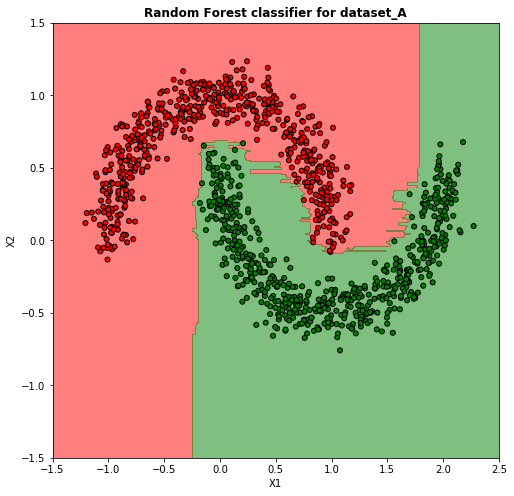

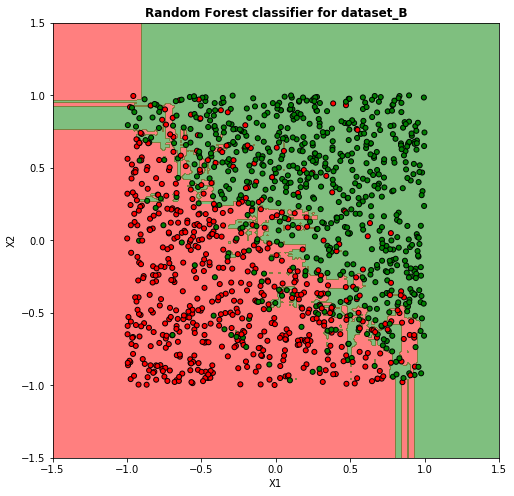

In [13]:
datasets = ['dataset_A.npz','dataset_B.npz']
path="E:\\5th sem\\prml\\prog assgn\\Archive (2)\\"
for file in datasets:
# loading the data
    data = np.load(file)

    X_train = data["arr_0"]
    Y_train = data["arr_1"]
    X_test = data["arr_2"]
    Y_test = data["arr_3"]
    
    N = X_train.shape[0]
    sp=np.int(0.8*N)
    x_train = X_train[:sp,:]
    y_train = Y_train[:sp]
    x_val = X_train[sp:,:]
    y_val = Y_train[sp:]
    
    x_plot = X_train[:sp,:]
    y_plot = Y_train[:sp]
    
    x_min = round(x_train[:, 0].min())-0.5
    y_min = round(x_train[:, 1].min())-0.5
    x_max = round(x_train[:, 0].max())+0.5
    y_max = round(x_train[:, 1].max())+0.5    
    
    # axes limits
    
    # Generate meshgrids
    x1 = np.linspace(x_min, x_max, 300)
    x2 = np.linspace(y_min, y_max, 300)
    
    xx, yy = np.meshgrid(x1, x2)
    

    rf = split_Eval_criteria["accuracy"][file][3]

    Z = eval_random_forest(rf, np.c_[xx.ravel(), yy.ravel()])
 
    Z = Z.reshape(xx.shape)
    
    fig=plt.figure(figsize = (8,8))
    ax=fig.add_subplot(1,1,1)
    ax.contourf(xx, yy, Z,colors = ('r','g'), levels =np.arange(-1,2), alpha = 0.5)
    ax.scatter(x_plot[:,0], x_plot[:,1], c = ['g' if i==1 else 'r' for i in y_plot], s = 25,edgecolor='black')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.title("Random Forest classifier for {}".format(file[:-4]),fontweight='bold')
    plt.xlabel("X1")
    plt.ylabel("X2")
plt.show()

        
   


# 5 AdaBoost

Write code for learning using AdaBoost below. Use 3 different weak learners below. (You may reuse code written above)

1. 1 node decision tree 
2. Decision tree of fixed depth = 3 (Root, child, grand child)
3. Decision tree of fixed depth = 7 (Root, child, grand child, ..., great^4 grand child)

Run for 50 iterations. You may use the accuracy split criterion for all the three weak learners.

Write code for running in the next cell. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  plot the train and test accuracy vs iterations. A total of 12 plots is expected. 4 datasets * 3 weak learners. Each plot should contain two curves, train and test error.  

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each weak learner setting. A total of 6 contourf style plots are expected here. Do this in the last codeWrite cell for this question.

Summarise your observations in the last textwrite cell.

In [2]:
class Decision_stump: # This can be Root of the tree, sub-node or Leaf Node
    def __init__(self, sp_col, val, que, label):
        self.left = None
        self.right = None
        self.split_col = sp_col
        self.thres_val = val
        self.label = label        
        self.que_type = que

def get_potential_splits(data):    
   
    potential_splits = {}
    column_indices = list(range(data.shape[1]- 1))
        
    for col_ind in column_indices:
        x_min, x_max = data[:,col_ind].min() , data[:,col_ind].max() 
        if (x_min != x_max):
            
            potential_splits[col_ind]=np.linspace(x_min + (x_max-x_min)/10, x_max - (x_max-x_min)/10, 10).tolist()
    
    return potential_splits


def accuracy_ada(data, split_column, split_value,w):
    
    label_column = data[:, -1].reshape(-1,1)
    label_temp = np.zeros((data.shape[0], 2))
    for ind in range(data.shape[0]):
        if(data[ind, split_column] >= split_value):
            label_temp[ind, 0] = 1
            label_temp[ind, 1] = -1
        else:
            label_temp[ind, 0] = -1
            label_temp[ind, 1] = 1
            

    acc = np.sum(w.reshape(-1,1)*(label_temp == label_column), axis = 0)/w.sum()
    max_acc_loc = np.max(acc[:,None])
    max_acc_loc_ind = np.argmax(acc)
    return max_acc_loc, max_acc_loc_ind
    

def best_split_2(data, potential_splits, w): 
    best_split_col = 0
    best_split_value = 0
    question_type = 0

    max_accuracy = 0.0
    for col_ind in potential_splits:
        if(len(potential_splits[col_ind]) != 0):
            for value in potential_splits[col_ind]:
                current_accuracy, question_type = accuracy_ada(data, col_ind, value, w)

                if(current_accuracy >= max_accuracy):
                    best_split_col = col_ind
                    best_split_value = value
                    question_type = question_type
                    max_accuracy = current_accuracy
#    print('accuracy ada', max_accuracy)        
    return best_split_col, best_split_value, question_type

def split_data_2(data, split_feature, split_value, w, question_type = 0):
     
    if(question_type == 0):
        
        data_right = data[data[:, split_feature] >= split_value]
        data_left = data[data[:, split_feature] < split_value]
        w_right = w[data[:, split_feature] >= split_value]
        w_left = w[data[:, split_feature] < split_value]
    else:
        
        data_right = data[data[:, split_feature] <= split_value]
        data_left = data[data[:, split_feature] > split_value]
        w_right = w[data[:, split_feature] <= split_value]
        w_left = w[data[:, split_feature] > split_value]
    
    return data_left, data_right, w_left, w_right

    
def train_stump(X_train, Y_train, depth, w):
    data = np.concatenate((X_train, Y_train[:, None]), axis = 1)
    #print(data)
    m, n = data.shape
    
    if(len(np.unique(Y_train)) == 1): # either Y is all +1 or -1.
        return Decision_stump(None, None, None, Y_train[0])    
    
    if(depth == 0):
        label = -1 if (w @ Y_train)/w.sum() < 0 else 1
        return Decision_stump(None, None, None, label)
    
    depth -= 1    
    
    potential_splits = get_potential_splits(data)
    split_column, split_value, question_type = best_split_2(data, potential_splits, w)
    data_left, data_right, w_left, w_right = split_data_2(data, split_column, split_value, w, question_type)
    
    tree = Decision_stump(split_column,split_value, question_type, None)
    
    if len(data_left) == 0 or len(data_right) == 0:
        label = 0
        if len(data_left) == 0:
            label = -1 if (w_right @ data_right[:,-1])/w_right.sum() < 0 else 1
        else:
            label = -1 if (w_left @ data_left[:,-1])/w_left.sum() < 0 else 1
        return Decision_stump(None, None, None, label)
    
    tree = Decision_stump(split_column,split_value, question_type, None)
    tree.left = train_stump(data_left[:, :n-1], data_left[:, -1], depth, w_left)
    tree.right = train_stump(data_right[:, :n-1], data_right[:, -1], depth, w_right)
    
    return tree


def classify_sample(tree,X):
    if tree.que_type == None:
        return tree.label
    elif int(tree.que_type) == 0:
        if X[tree.split_col] >= tree.thres_val:
            if tree.label != None:
                return tree.label
            return classify_sample(tree.right,X)
        else:
            if tree.label != None:
                return tree.label
            return classify_sample(tree.left,X)
    elif int(tree.que_type) == 1:
        if X[tree.split_col] <= tree.thres_val:
            if tree.label != None:
                return tree.label
            return classify_sample(tree.right,X)
        else:
            if tree.label != None:
                return tree.label
            return classify_sample(tree.left,X)    
            
def eval_decision_tree(tree, test_X):
    Y_pred = []
    for i in test_X:
        ans = classify_sample(tree,i)
        Y_pred.append(ans)
    
    return np.array(Y_pred) 


def AdaBoost(X_train, Y_train, X_test, d, num_iters=50):    
    w = np.ones(Y_train.shape)
    h=0
    h_pred = 0
    g_h_train = []
    g_h_test=[]
    
    for i in range(num_iters):        
        tree = train_stump(X_train, Y_train, d, w)        
        Y_pred_train = eval_decision_tree(tree, X_train)
        gamma = (w @ (Y_pred_train == Y_train))/w.sum() - 0.5
        if gamma <= 0.5:
            beta = (0.5 + gamma) / (0.5 - gamma + 1e-3)        
            h+=(np.log(beta) * Y_pred_train)
            g_h_train.append(np.copy(h))
            power = abs(Y_pred_train - Y_train)/2
            power = [beta**i for i in power]
            w = w * power       
            Y_pred_test = eval_decision_tree(tree, X_test) 
            h_pred += (np.log(beta) * Y_pred_test)
            g_h_test.append(np.copy(h_pred))
            
        else:
            for _ in range(i,num_iters):
                g_h_test.append(np.copy(h_pred))
                g_h_train.append(np.copy(h))
            break
               
    return (g_h_train,g_h_test)

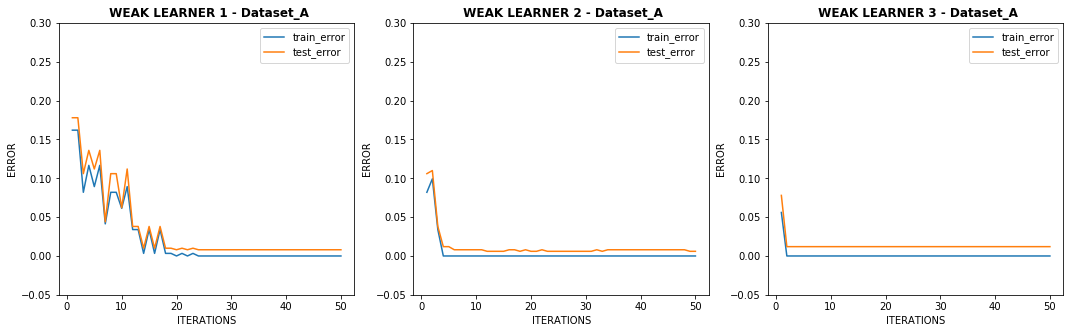

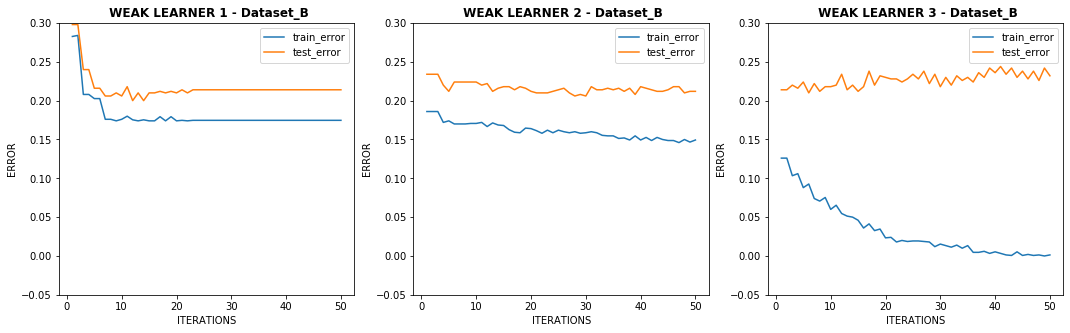

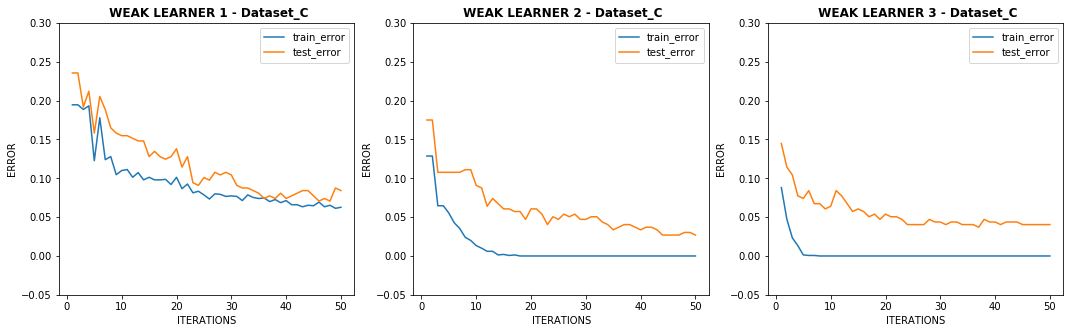

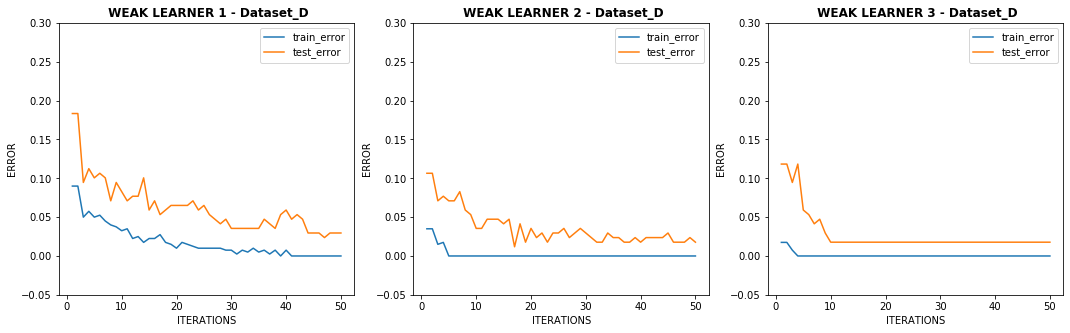

In [3]:
datasets = ['dataset_A.npz', 'dataset_B.npz','dataset_C.npz', 'dataset_D.npz']
path="E:\\5th sem\\prml\\prog assgn\\Archive (2)\\"
iter_list=[i for i in range(1,51)]
d=[1,3,7]
for file in datasets:
    ## loading the data
    data = np.load(file)

    X_train = data["arr_0"]
    Y_train = data["arr_1"]
    X_test = data["arr_2"]
    Y_test = data["arr_3"]

    fig=plt.figure(figsize = (18,5))

    for i in range(3):
        ax= fig.add_subplot(1,3,i+1)
        g_h_train,g_h_test = AdaBoost(X_train, Y_train, X_test, d[i], 50)
        train_error=[np.sum(np.sign(i) != Y_train)/len(Y_train) for i in g_h_train]
        test_error = [np.sum(np.sign(i) != Y_test)/len(Y_test) for i in g_h_test]
        ax.plot(iter_list, train_error, label='train_error')
        ax.plot(iter_list, test_error, label='test_error')
        plt.title(" WEAK LEARNER {} - D{}".format(i+1,file[1:-4]), fontweight='bold')
        ax.set_xlabel("ITERATIONS")
        ax.set_ylabel("ERROR")
        ax.set_ylim(-0.05,0.3)
        plt.legend()
    plt.show()

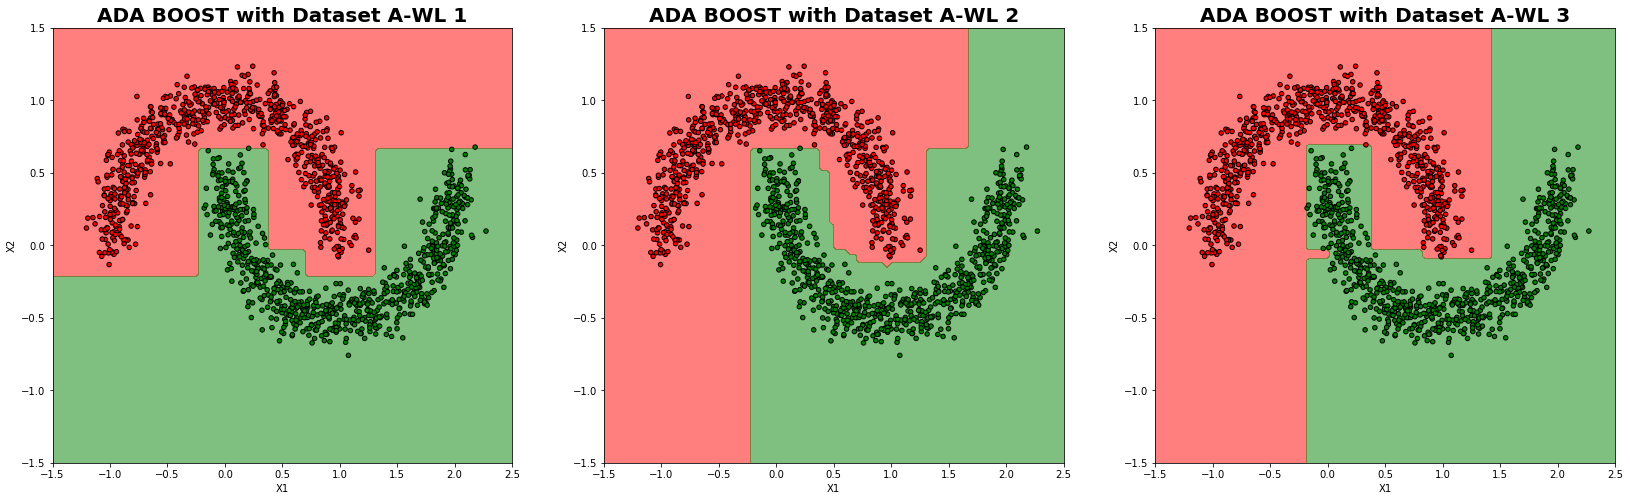

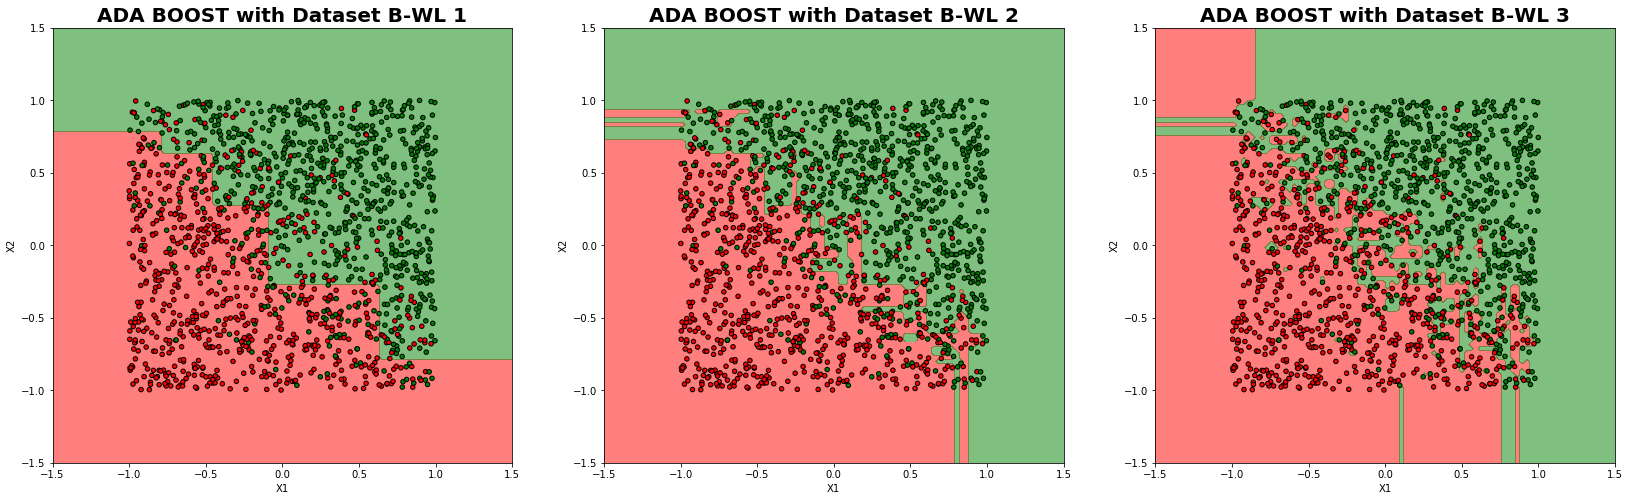

In [4]:
# Codewrite cell 
# Plots for iteration vs error here
datasets = ['dataset_A.npz', 'dataset_B.npz']
path="E:\\5th sem\\prml\\prog assgn\\Archive (2)\\"
iter_list=[i for i in range(1,51)]
d=[1,3,7]
for file in datasets:
    ## loading the data
    data = np.load(file)

    X_train = data["arr_0"]
    Y_train = data["arr_1"]
    X_test = data["arr_2"]
    Y_test = data["arr_3"]

    x_min = round(X_train[:, 0].min())-0.5
    y_min = round(X_train[:, 1].min())-0.5
    x_max = round(X_train[:, 0].max())+0.5
    y_max = round(X_train[:, 1].max())+0.5

    # Generate meshgrids
    x1 = np.linspace(x_min, x_max, 100)
    x2 = np.linspace(y_min, y_max, 100)

    xx, yy = np.meshgrid(x1, x2)
    
    fig=plt.figure(figsize = (28,8))

    for i in range(3):
        ax= fig.add_subplot(1,3,i+1)
        Z= AdaBoost(X_train, Y_train,np.c_[xx.ravel(), yy.ravel()], d[i], 50)[1][-1]
        Z= np.array([np.sign(i) for i in Z])
        Z= Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z,colors = ('r','g'), levels =np.arange(-1,2), alpha = 0.5)
        ax.scatter(X_train[:,0], X_train[:,1], c = ['g' if i==1 else 'r' for i in Y_train], s = 20,edgecolor='black')
        plt.title("ADA BOOST with Dataset {}-WL {}".format(file[-5],i%3+1),fontweight='bold',fontsize=20)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        plt.xlabel("X1")
        plt.ylabel("X2")
    plt.show()

## OBSERVATIONS

1) AdaBoost implements boosting, wherein a set of weak classifiers is connected in series such that 
   each weak classifier tries to improve the classification of samples that were misclassified by the 
   previous weak classifier.

2) Adaboost on Datasets A,C and D results in almost 0 train error almost 0 or very less test error.
   Weak learner 3 has performed best on Datasets A,C,D ,but it seems to slightly overfit in the case of Dataset B(noisy dataset)   Training error decreases exponentially fast with the iterations when  compared to other two weak learners.

3) Weak learners 2 and 3 form complex decision boundaries which can be visulaized in the case of dataset B

4) On well separable datasets like A,C and D, boosting performs much better when individual weak learners have more than 1 node.    As the depth of each weak learner is increased, there has been an improvement in the performance. It has also resulted in        faster convergence to optimum which can be visualized from the error plots.
